<a href="https://colab.research.google.com/github/ggrindstaff/Connectivity/blob/Automated-Earthwork-Detection/Colab_notebooks/Synthetic_BERM_PlottingCycles_R1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependencies and import data

Install ripser package, cython dependency already available

In [1]:
!git clone https://github.com/ggrindstaff/ripser.py
%cd ripser.py
!pip install -e .

Cloning into 'ripser.py'...
remote: Enumerating objects: 3437, done.
remote: Counting objects: 100% (416/416), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 3437 (delta 201), reused 340 (delta 169), pack-reused 3021
Receiving objects: 100% (3437/3437), 20.33 MiB | 14.36 MiB/s, done.
Resolving deltas: 100% (2002/2002), done.
/content/ripser.py
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/ripser.py
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Building editable for ripser (pyproject.toml) ... done
  Created wheel for ripser: filename=ripser-0.6.2-0.editable-cp310-cp310-linux_x86_64.whl size=5992 sha256=63

In [2]:
def img_to_sparse(img):
  # Modified from source code
    m, n = img.shape

    idxs = np.arange(m * n).reshape((m, n))

    I = idxs.flatten()
    J = idxs.flatten()
    V = img.flatten()

    # Connect 8 spatial neighbors
    tidxs = np.ones((m + 2, n + 2), dtype=np.int64) * np.nan
    tidxs[1:-1, 1:-1] = idxs

    tD = np.ones_like(tidxs) * np.nan
    tD[1:-1, 1:-1] = img

    for di in [-1, 0, 1]:
        for dj in [-1, 0, 1]:

            if di == 0 and dj == 0:
                continue

            thisJ = np.roll(np.roll(tidxs, di, axis=0), dj, axis=1)
            thisD = np.roll(np.roll(tD, di, axis=0), dj, axis=1)
            thisD = np.maximum(thisD, tD)

            # Deal with boundaries
            boundary = ~np.isnan(thisD)
            thisI = tidxs[boundary]
            thisJ = thisJ[boundary]
            thisD = thisD[boundary]

            I = np.concatenate((I, thisI.flatten()))
            J = np.concatenate((J, thisJ.flatten()))
            V = np.concatenate((V, thisD.flatten()))

    return sparse.coo_matrix((V, (I, J)), shape=(idxs.size, idxs.size))


def cocycles_to_plot(cocycles,d,rotate=False):
  m,n = d.shape
  birthloc = [cocycles[0][i][0][0] for i in range(len(cocycles[0]))]
  xloc = []
  yloc = []
  for ind in birthloc:
    if rotate==False:
      yi = int(ind/n)
      xi = ind%n
    if rotate==True:
      yi = m-int(ind/n)-1
      xi = ind%n  
    xloc.append(xi)
    yloc.append(yi)
  return xloc,yloc

Code based on 
https://ripser.scikit-tda.org/en/latest/notebooks/Lower%20Star%20Image%20Filtrations.html

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
import PIL
import random
# import latex

from persim import plot_diagrams, bottleneck, sliced_wasserstein, wasserstein, bottleneck_matching, PersImage,PersistenceImager, landscapes
from ripser import ripser, lower_star_img, Rips
from persim.persistent_entropy import *
from scipy import stats
from scipy import sparse


plt.rcParams.update(plt.rcParamsDefault)

# Load data and compute persistence diagrams

Takes about 0.07 seconds per image, for 100x100 pixel images. For berm data, about 6 seconds per image.

In [4]:
directory = 'https://raw.githubusercontent.com/ggrindstaff/Connectivity/Automated-Earthwork-Detection/'
name = 'berms'
loc = 'Berms/'
files = ['OBJ2/DEM/AOI_OBJ2_untreated.csv',
         'OBJ2/DEM/AOI_OBJ2_untreated_AddedStruct.csv',
         'OBJ4/DEM/AOI_OBJ4_untreated.csv',
         'OBJ4/DEM/AOI_OBJ4_untreated_AddedStruct.csv',
         'OBJ2/DEM/AOI_OBJ2_Case1Taper_converted.csv',
         'OBJ2/DEM/AOI_OBJ2_Case2Breach_converted.csv',
         'OBJ2/DEM/AOI_OBJ2_untreated_AddedStruct_Case3Terrace.csv',
         'OBJ4/DEM/AOI_OBJ4_Case1Taper_converted.csv',
         'OBJ4/DEM/AOI_OBJ4_Case2Breach_converted.csv', 
         'OBJ4/DEM/AOI_OBJ4_untreated_AddedStruct_Case3Terrace.csv'
         ]

N=len(files)

import scipy.ndimage

dgm0 = {i:[] for i in range(N)} # output 0th homology data
dgm0_adj= {i:[] for i in range(N)} # output 0th homology data
dgm1 = {i:[] for i in range(N)} # output 1th homology data
data = {i:[] for i in range(N)} # DEM data for examples
data2 = {i:[] for i in range(N)} # DEM data with noise for examples
cocycles = {i:[] for i in range(N)}

for i in range(N):
  # print(i)
  try:
    data[i] = np.loadtxt(directory+loc+files[i],delimiter=",",skiprows=1)
  except:
    data[i] = np.loadtxt(directory+loc+files[i])
    data[i] = data[i] - np.nanmax(data[i]) + 5
  if i in [6,9]:
    data[i] = data[i] - np.nanmax(data[i]) + 5
  # if i>3:
  #   d = ndimage.interpolation.zoom(data[i],.5) #decimate resolution
  # else:
  #   d = data[i]
  d = data[i]
  data2[i] = d + 0.00001*np.random.rand(d.shape[0],d.shape[1])
  if 'stockpond' in files[i]:
    dgm0[i] = lower_star_img(data2[i])    #sublevel set filtration
  #  dgm1[i] = lower_star_img(-data2[i],1) #1st homology of superlevel set
  else:
    sparseDM = img_to_sparse(data2[i])
    rip = ripser(-sparseDM, distance_matrix=True, maxdim=0, do_cocycles=True)
    dgm0[i] = rip["dgms"][0]
    cocycles[i] = rip["cocycles"]
 

#Plot cycle locations

In [6]:
# xpos = np.array(xcycle).flatten()

In [5]:
def persitence_subs(dgm_original,dgm_altered,idxs,mask0,mask1):
  birth_original = np.array([p[0] for p in dgm_original])[mask0]
  death_original = np.array([p[1] for p in dgm_original])[mask0]
  birth_synth = np.array([p[0] for p in dgm_altered])[mask1]
  death_synth = np.array([p[1] for p in dgm_altered])[mask1]
  persistence_original = death_original-birth_original
  persistence_synth = death_synth-birth_synth
  mask_original = (False)
  mask_synth = (persistence_synth>=thresh) & (persistence_synth<=max_thresh)
  dgm_berm_original = dgm_original[mask_original]
  dgm_berm_synth = dgm_altered[idxs]

  birth_original_berm = np.array([p[0] for p in dgm_berm_original])
  death_original_berm = np.array([p[0] for p in dgm_berm_original])
  birth_synth_berm = np.array([p[0] for p in dgm_berm_synth])
  death_synth_berm = np.array([p[1] for p in dgm_berm_synth])
  pers_original_berm = death_original_berm-birth_original_berm
  pers_synth_berm = death_synth_berm-birth_synth_berm

  births = [birth_original,birth_synth]
  deaths = [death_original,death_synth]
  persistence = [persistence_original,persistence_synth]

  births_berm = [birth_original_berm,birth_synth_berm]
  deaths_berm = [death_original_berm,death_synth_berm]
  persistence_berm = [pers_original_berm,pers_synth_berm]
  return births,deaths,persistence,births_berm,deaths_berm,persistence_berm

In [17]:
persheight

array([2.65259373, 2.80566645, 1.71838665, 2.89783239, 2.61975527,
       0.53174114, 2.73792076, 2.66913223, 0.9621582 , 0.50494385,
       2.64862823])

In [34]:
len(xcycle),len(births_berm[i])

(11, 11)

rats


<ipython-input-63-6d2da8d20876>:519: RuntimeWarning: divide by zero encountered in double_scalars
  feature_width = feature_size / feature_length
<ipython-input-63-6d2da8d20876>:628: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig2.tight_layout()


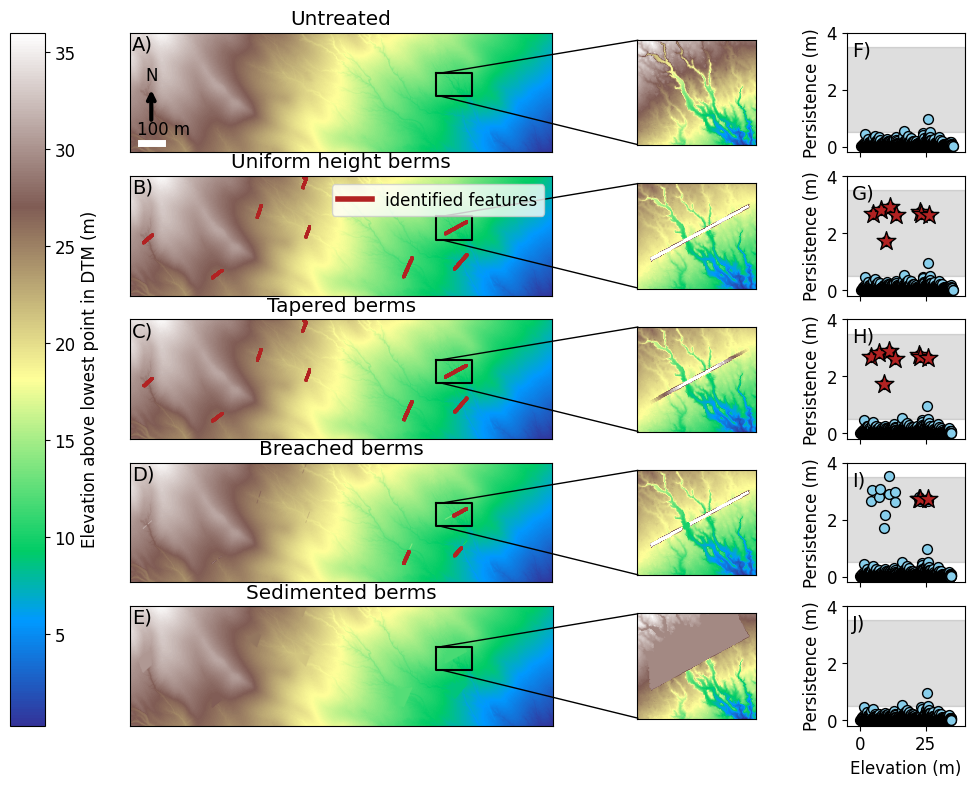

In [63]:
# version of figure with each site separately
from scipy.spatial.distance import pdist, squareform
%matplotlib inline
plt.rcParams.update({'font.size': 14})
import matplotlib.gridspec as gridspec
from skimage import measure
from skimage import filters
from matplotlib.patches import ConnectionPatch

xmin = 1475
xmax = 1600
ymin = 190
ymax = 301
xpos = -8

%matplotlib inline
plt.rcParams.update({'font.size': 12})

thresh = 0.5
max_thresh = 3.5
noisethresh = 7
minelev = 31
minsize = 100
maxsize = 2000
maxsize_stockpond = 2000
minlength = 40
maxlength = 250
maxwidth = 15
minhratio = 1.
maxhratio = 5.
cmap='terrain'

fig2 = plt.figure(figsize = (7.25*1.7,6*1.5))
spec2 = gridspec.GridSpec(ncols=23, nrows=5, figure=fig2)
ax0 = fig2.add_subplot(spec2[:, 0]) # this is the colorbar
ax1 = fig2.add_subplot(spec2[0, 1:15]) # this is the elevation image without berms
ax2 = fig2.add_subplot(spec2[1, 1:15]) # elevation image with berms
ax3 = fig2.add_subplot(spec2[0, 20:]) # PD without berms
ax4 = fig2.add_subplot(spec2[1, 20:]) # PD with berms

# add in some zoom-ins
ax10 = fig2.add_subplot(spec2[0, 15:18])
ax11 = fig2.add_subplot(spec2[1, 15:18])
ax12 = fig2.add_subplot(spec2[2, 15:18])
ax13 = fig2.add_subplot(spec2[3, 15:18])
ax14 = fig2.add_subplot(spec2[4, 15:18])

# ax5 = fig2.add_subplot(spec2[2:, 0]) # this is the colorbar
ax6 = fig2.add_subplot(spec2[2, 1:15]) # this is the elevation image without berms
ax7 = fig2.add_subplot(spec2[3, 1:15]) # elevation image with berms
ax8 = fig2.add_subplot(spec2[2, 20:]) # PD without berms
ax9 = fig2.add_subplot(spec2[3, 20:]) # PD with berms
ax97 = fig2.add_subplot(spec2[4, 1:15]) # PD with berms
ax98 = fig2.add_subplot(spec2[4, 20:]) # PD with berms

idx_save = []

xcycles = []
ycycles = []

textlabel = ['A)','B)','C)','D)','E)']
axs = [ax1,ax2,ax6,ax7,ax97]
masks = []
js = [0,1,4,5,6]
for i in range(len(js)):
  ax = axs[i]
  j = js[i]
  shw = ax.imshow(data2[j]+minelev, cmap = cmap, )
  ax.text(10,80,textlabel[i],fontsize=14,c='black')
  ax.set_xticks([])
  ax.set_yticks([])
  idxs = np.arange(dgm0[j].shape[0])
  idxs = idxs[np.abs(dgm0[j][:, 1] - dgm0[j][:, 0]) > thresh]
  xvals, yvals = cocycles_to_plot(cocycles[j],data2[j],rotate=False)
  xvals, yvals = np.array(xvals), np.array(yvals)
  mask_all = (xvals>noisethresh)&(xvals<len(data2[j][0])-noisethresh)&(yvals>noisethresh)&(yvals<len(data2[j])-noisethresh)
  masks.append(mask_all)
  xcycle = np.array(xvals)[idxs]
  ycycle = np.array(yvals)[idxs]
  mask = (xcycle>noisethresh)&(xcycle<len(data2[j][0])-noisethresh)&(ycycle>noisethresh)&(ycycle<len(data2[j])-noisethresh)
  xcycle = xcycle[mask]
  ycycle = ycycle[mask]
  idxs = idxs[mask]
  idx_save.append(idxs)
  counter = len(xcycle)
  xcycles.append(xcycle)
  ycycles.append(ycycle)


  # # plot cycle locations as stars
  # ax.scatter(xcycle,ycycle,color='firebrick', marker='*',clip_on=False,
  #            s=200,edgecolor = 'k',label = 'identified features',
  #            )

  

  if i in [0]:
    ax.plot([50,150],[520,520],lw=5,c='white')
    ax.text(30,480,'100 m')
    # ax.legend(loc='upper right')

cbar = fig2.colorbar(shw, cax=ax0, shrink=1)
cbar.set_label('Elevation above lowest point in DTM (m)')


births,deaths,persistence,births_berm,deaths_berm,persistence_berm = persitence_subs(dgm0[0],dgm0[1],idx_save[1],masks[0],masks[1])

# instead, plot identified features

ax = ax2
i = 1
xcycle = xcycles[i]
ycycle = ycycles[i]

mask_final = []
for l in range(len(xcycle)):
  
  splot = np.where((data2[i]> -deaths_berm[1][l]) & (data2[i]<=-births_berm[1][l]),1,0)



  dist = 10

  all_labels = measure.label(splot)
  blobs_labels = measure.label(splot, background=0)

  poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist,xcycle[l]-dist:xcycle[l]].flatten()))
  poss_comps = [p for p in poss_comps if p>0]

  if len(poss_comps)==0:
      dist1 = dist*2
      poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist1,xcycle[l]-dist1:xcycle[l]].flatten()))
      poss_comps = [p for p in poss_comps if p>0]
  if len(poss_comps)>1:
    dist1 = int(dist/2)
    poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist1,xcycle[l]-dist1:xcycle[l]].flatten()))
    poss_comps = [p for p in poss_comps if p>0]
    if len(poss_comps)>1:
      dist1 = int(dist/4)
      poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist1,xcycle[l]-dist1:xcycle[l]].flatten()))
      poss_comps = [p for p in poss_comps if p>0]
    if len(poss_comps)==0:
      dist1 = int(dist)
      poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist1,xcycle[l]-dist1:xcycle[l]].flatten()))
      poss_comps = [p for p in poss_comps if p>0]

  blob_thisonly = np.where(blobs_labels==poss_comps[0],1,np.nan)

  # ax.imshow(blob_thisonly, cmap='Reds_r',vmax=1,zorder = 100)
  # instead, plot as scatter points so it can be bolder
  blob_points = np.argwhere(~np.isnan(blob_thisonly))
  blob_ys = [p[0] for p in blob_points]
  blob_xs = [p[1] for p in blob_points]

  splot_height = data2[i][blobs_labels==poss_comps[0]]
  meanheight = splot_height-np.nanmin(splot_height)
  meanheight = np.nanmean(meanheight)
  persheight = deaths_berm[1][l]-births_berm[1][l]
  heightratio = persheight / meanheight

  # filter based on size and length
  feature_size = len(blob_points)
  num_features = 0
  if feature_size<maxsize_stockpond:
      D = pdist(blob_points)
      D = squareform(D)
      feature_length, [I_row, I_col] = np.nanmax(D), np.unravel_index( np.argmax(D), D.shape )
      feature_width = feature_size / feature_length
      # print(N)
  else:
      feature_length = 1
      feature_width = 1

  mask = (feature_size>minsize) & (feature_size<maxsize) &(feature_length>minlength) & (feature_length<maxlength) & (feature_width<maxwidth) & (feature_length> 6*feature_width)
  
  if mask:
      ax.scatter(blob_xs, blob_ys, c = 'firebrick', s = 1, label = None)
      #         print(l, feature_size, feature_length, feature_width, heightratio, '(',xcycle[l],',',ycycle[l],')')
      mask_final.append(True)
      num_features += 1
  else:
      mask_final.append(False)



ax.plot([0,1],[0,1],c='firebrick',lw=4,zorder = -1,label = 'identified features')
ax.legend()


# end plotting identified features

keys = [0,1]
axs = [ax3,ax4]
textlabel = ['G)','H)']
for key in keys:
  ax = axs[key]
  #Plot horizontal
  ax.scatter((births[key]+deaths[key])/2+4.5,
            persistence[key],
            label='background',c='skyblue',edgecolor = 'k',s=50, )
  try:
    ax.scatter((births_berm[key]+deaths_berm[key])[mask_final]/2+4.5,
              persistence_berm[key][mask_final],c='firebrick',edgecolor='k',s=200,label='berms',
              marker = '*')
  except:
    print('rats')
  ax.axhspan(thresh,max_thresh,
                  facecolor='k',alpha=0.13,edgecolor = 'k',zorder = -1)
  ax.set_ylabel("Persistence (m)")
  # ax.text(-4,2.6,textlabel[key],fontsize = 14)
  i = i+1
  # if key==0:
  #   ax.legend(loc='upper right')

births,deaths,persistence,births_berm,deaths_berm,persistence_berm = persitence_subs(dgm0[0],dgm0[6],idx_save[4],masks[0],masks[4])

# instead, plot identified features

ax = ax97
i = 4
j = 6
xcycle = xcycles[i]
ycycle = ycycles[i]
mask_final = []
for l in range(len(xcycle)):

  if abs(deaths_berm[1][l]-births_berm[1][l])>3:
    colorplot = 'violet'
    zorder = 20
    alpha = 1
  else:
    colorplot = 'firebrick'
    zorder = 30
    alpha = 1
  splot = np.where((data2[j]> -deaths_berm[1][l]) & (data2[j]<=-births_berm[1][l]),1,0)



  dist = 10

  all_labels = measure.label(splot)
  blobs_labels = measure.label(splot, background=0)


  poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist,
                                     max(xcycle[l]-dist,0):xcycle[l]].flatten()))
  poss_comps = [p for p in poss_comps if p>1]
  # print(l,poss_comps)

  if len(poss_comps)==0:
      dist1 = dist*2
      poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist1,
                                         max(xcycle[l]-dist,0):xcycle[l]].flatten()))
      poss_comps = [p for p in poss_comps if p>1]
  if len(poss_comps)>1:
    dist1 = int(dist/2)
    poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist1,
                                       max(xcycle[l]-dist,0):xcycle[l]].flatten()))
    poss_comps = [p for p in poss_comps if p>1]
    while len(poss_comps)>1:
      dist1 = int(dist1/2)
      poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist1,
                                         max(xcycle[l]-dist,0):xcycle[l]].flatten()))
      poss_comps = [p for p in poss_comps if p>1]
    if len(poss_comps)==0:
      # print('rat',dist1)
      if dist1==0:
        dist1 = 1
      else:
        dist1 = round(dist1*2)
      poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist1,
                                         max(xcycle[l]-dist,0):xcycle[l]].flatten()))
      poss_comps = [p for p in poss_comps if p>1]

  if l==9:
    blob_thisonly = np.where(blobs_labels==14,1,np.nan)
  else:
    blob_thisonly = np.where(blobs_labels==poss_comps[0],1,np.nan)

  # ax.imshow(blob_thisonly, cmap='Reds_r',vmax=1,zorder = 100)
  # instead, plot as scatter points so it can be bolder
  blob_points = np.argwhere(~np.isnan(blob_thisonly))
  blob_ys = [p[0] for p in blob_points]
  blob_xs = [p[1] for p in blob_points]
  splot_height = data2[j][blobs_labels==poss_comps[0]]
  meanheight = splot_height-np.nanmin(splot_height)
  meanheight = np.nanmean(meanheight)
  persheight = deaths_berm[1][l]-births_berm[1][l]
  heightratio = persheight / meanheight

  # filter based on size and length
  feature_size = len(blob_points)
  num_features = 0
  if feature_size<maxsize_stockpond:
      D = pdist(blob_points)
      D = squareform(D)
      feature_length, [I_row, I_col] = np.nanmax(D), np.unravel_index( np.argmax(D), D.shape )
      feature_width = feature_size / feature_length
      # print(N)
  else:
      feature_length = 1
      feature_width = 1

  mask = (feature_size>minsize) & (feature_size<maxsize) &(feature_length>minlength) & (feature_length<maxlength) & (feature_width<maxwidth) & (feature_length> 6*feature_width)
  
  if mask:
      ax.scatter(blob_xs, blob_ys, c = 'firebrick', s = 1, label = None)
      #         print(l, feature_size, feature_length, feature_width, heightratio, '(',xcycle[l],',',ycycle[l],')')
      mask_final.append(True)
      num_features += 1
  else:
      mask_final.append(False)

textlabel = ['','J)',]
key = 1
ax = ax98
#Plot horizontal
ax.scatter((births[key]+deaths[key])/2+4.5,
          persistence[key],
          label='background',c='skyblue',edgecolor = 'k',s=50, )
ax.scatter((births_berm[key]+deaths_berm[key])[mask_final]/2+4.5,
            persistence_berm[key][mask_final],c='firebrick',edgecolor='k',s=200,label='berms',
            marker = '*')
ax.axhspan(thresh,max_thresh,
                facecolor='k',alpha=0.13,edgecolor = 'k',zorder = -1)
ax.set_ylabel("Persistence (m)")
# ax.text(-4,2.6,textlabel[key],fontsize = 14)
i = i+1
# if key==0:
#   ax.legend(loc='upper right')


births,deaths,persistence,births_berm,deaths_berm,persistence_berm = persitence_subs(dgm0[0],dgm0[4],idx_save[2],masks[0],masks[2])

# instead, plot identified features

ax = ax6
i = 2
j = 4
xcycle = xcycles[i]
ycycle = ycycles[i]
mask_final = []
for l in range(len(xcycle)):
  
  splot = np.where((data2[j]> -deaths_berm[1][l]) & (data2[j]<=-births_berm[1][l]),1,0)



  dist = 10

  all_labels = measure.label(splot)
  blobs_labels = measure.label(splot, background=0)

  poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist,xcycle[l]-dist:xcycle[l]].flatten()))
  poss_comps = [p for p in poss_comps if p>1]

  if len(poss_comps)==0:
      dist1 = dist*2
      poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist1,xcycle[l]-dist1:xcycle[l]].flatten()))
      poss_comps = [p for p in poss_comps if p>1]
  if len(poss_comps)>1:
    dist1 = int(dist/2)
    poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist1,xcycle[l]-dist1:xcycle[l]].flatten()))
    poss_comps = [p for p in poss_comps if p>1]
    if len(poss_comps)>1:
      dist1 = int(dist/4)
      poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist1,xcycle[l]-dist1:xcycle[l]].flatten()))
      poss_comps = [p for p in poss_comps if p>1]
    if len(poss_comps)==0:
      dist1 = int(dist)
      poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist1,xcycle[l]-dist1:xcycle[l]].flatten()))
      poss_comps = [p for p in poss_comps if p>1]

  blob_thisonly = np.where(blobs_labels==poss_comps[0],1,np.nan)

  # ax.imshow(blob_thisonly, cmap='Reds_r',vmax=1,zorder = 100)
  # instead, plot as scatter points so it can be bolder
  blob_points = np.argwhere(~np.isnan(blob_thisonly))
  blob_ys = [p[0] for p in blob_points]
  blob_xs = [p[1] for p in blob_points]
  # ax.scatter(blob_xs, blob_ys, c = 'firebrick', s = 1)
  splot_height = data2[j][blobs_labels==poss_comps[0]]
  meanheight = splot_height-np.nanmin(splot_height)
  meanheight = np.nanmean(meanheight)
  persheight = deaths_berm[1][l]-births_berm[1][l]
  heightratio = persheight / meanheight

  # filter based on size and length
  feature_size = len(blob_points)
  num_features = 0
  if feature_size<maxsize_stockpond:
      D = pdist(blob_points)
      D = squareform(D)
      feature_length, [I_row, I_col] = np.nanmax(D), np.unravel_index( np.argmax(D), D.shape )
      feature_width = feature_size / feature_length
      # print(N)
  else:
      feature_length = 1
      feature_width = 1

  mask = (feature_size>minsize) & (feature_size<maxsize) &(feature_length>minlength) & (feature_length<maxlength) & (feature_width<maxwidth) & (feature_length> 6*feature_width)
  
  if mask:
      ax.scatter(blob_xs, blob_ys, c = 'firebrick', s = 1, label = None)
      #         print(l, feature_size, feature_length, feature_width, heightratio, '(',xcycle[l],',',ycycle[l],')')
      mask_final.append(True)
      num_features += 1
  else:
      mask_final.append(False)

  if l==6:
    ax12.scatter(np.array(blob_xs)-xmin, 
              np.array(blob_ys)-ymin, c = 'firebrick', s = .5, alpha=0.1)


textlabel = ['','G)',]
key = 1
ax = ax8
#Plot horizontal
ax.scatter((births[key]+deaths[key])/2+4.5,
          persistence[key],
          label='background',c='skyblue',edgecolor = 'k',s=50, )
ax.scatter((births_berm[key]+deaths_berm[key])[mask_final]/2+4.5,
            persistence_berm[key][mask_final],c='firebrick',edgecolor='k',s=200,label='berms',
            marker = '*')
ax.axhspan(thresh,max_thresh,
                facecolor='k',alpha=0.13,edgecolor = 'k',zorder = -1)
ax.set_ylabel("Persistence (m)")
# ax.text(-4,2.6,textlabel[key],fontsize = 14)
i = i+1
# if key==0:
#   ax.legend(loc='upper right')

births,deaths,persistence,births_berm,deaths_berm,persistence_berm = persitence_subs(dgm0[0],dgm0[5],idx_save[3],masks[0],masks[3])

# instead, plot identified features

ax = ax7
i = 3
j = 5
xcycle = xcycles[i]
ycycle = ycycles[i]
mask_final = []
for l in range(len(xcycle)):

  if abs(deaths_berm[1][l]-births_berm[1][l])>3:
    colorplot = 'violet'
    zorder = 20
    alpha = 1
  else:
    colorplot = 'firebrick'
    zorder = 30
    alpha = 1
  splot = np.where((data2[j]> -deaths_berm[1][l]) & (data2[j]<=-births_berm[1][l]),1,0)



  dist = 10

  all_labels = measure.label(splot)
  blobs_labels = measure.label(splot, background=0)


  poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist,
                                     max(xcycle[l]-dist,0):xcycle[l]].flatten()))
  poss_comps = [p for p in poss_comps if p>1]
  # print(l,poss_comps)

  if len(poss_comps)==0:
      dist1 = dist*2
      poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist1,
                                         max(xcycle[l]-dist,0):xcycle[l]].flatten()))
      poss_comps = [p for p in poss_comps if p>1]
  if len(poss_comps)>1:
    dist1 = int(dist/2)
    poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist1,
                                       max(xcycle[l]-dist,0):xcycle[l]].flatten()))
    poss_comps = [p for p in poss_comps if p>1]
    while len(poss_comps)>1:
      dist1 = int(dist1/2)
      poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist1,
                                         max(xcycle[l]-dist,0):xcycle[l]].flatten()))
      poss_comps = [p for p in poss_comps if p>1]
    if len(poss_comps)==0:
      # print('rat',dist1)
      if dist1==0:
        dist1 = 1
      else:
        dist1 = round(dist1*2)
      poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist1,
                                         max(xcycle[l]-dist,0):xcycle[l]].flatten()))
      poss_comps = [p for p in poss_comps if p>1]

  if l==9:
    blob_thisonly = np.where(blobs_labels==14,1,np.nan)
  else:
    blob_thisonly = np.where(blobs_labels==poss_comps[0],1,np.nan)

  # ax.imshow(blob_thisonly, cmap='Reds_r',vmax=1,zorder = 100)
  # instead, plot as scatter points so it can be bolder
  blob_points = np.argwhere(~np.isnan(blob_thisonly))
  blob_ys = [p[0] for p in blob_points]
  blob_xs = [p[1] for p in blob_points]
  # ax.scatter(blob_xs, blob_ys, c = colorplot, s = 1, zorder = zorder, alpha=alpha)

  splot_height = data2[j][blobs_labels==poss_comps[0]]
  meanheight = splot_height-np.nanmin(splot_height)
  meanheight = np.nanmean(meanheight)
  persheight = deaths_berm[1][l]-births_berm[1][l]
  heightratio = persheight / meanheight

  # filter based on size and length
  feature_size = len(blob_points)
  num_features = 0
  if feature_size<maxsize_stockpond:
      D = pdist(blob_points)
      D = squareform(D)
      feature_length, [I_row, I_col] = np.nanmax(D), np.unravel_index( np.argmax(D), D.shape )
      feature_width = feature_size / feature_length
      # print(N)
  else:
      feature_length = 1
      feature_width = 1

  mask = (feature_size>minsize) & (feature_size<maxsize) &(feature_length>minlength) & (feature_length<maxlength) & (feature_width<maxwidth) & (feature_length> 6*feature_width)
  
  if mask:
      ax.scatter(blob_xs, blob_ys, c = 'firebrick', s = 1, label = None)
      #         print(l, feature_size, feature_length, feature_width, heightratio, '(',xcycle[l],',',ycycle[l],')')
      mask_final.append(True)
      num_features += 1
  else:
      mask_final.append(False)

  # if l in [12,13]:
  #   ax13.scatter(np.array(blob_xs)-xmin, 
  #             np.array(blob_ys)-ymin, c = colorplot, s = .5, zorder = zorder, alpha=.1)

  



ax = ax9
textlabel = ['H)','I)']
key = 1
#Plot horizontal
ax.scatter(((births[key]+deaths[key])/2+4.5),
          persistence[key],
          label='background',c='skyblue',edgecolor = 'k',s=50, )
mask = persistence_berm[key][mask_final] < 3
bsmall = births_berm[key][mask_final][mask]
dsmall = deaths_berm[key][mask_final][mask]
psmall = persistence_berm[key][mask_final][mask]
ax.scatter(((bsmall+dsmall)/2+4.5),
            psmall,c='firebrick',edgecolor='k',s=200,label='berms',
            marker = '*')
# mask = persistence_berm[key]>= 3
# bbig = births_berm[key][mask]
# dbig = deaths_berm[key][mask]
# pbig = persistence_berm[key][mask]
# ax.scatter(((bbig+dbig)/2+4.5),
#             pbig,c='violet',edgecolor='k',s=200,label='berms',
#             marker = '*',zorder = 10000)
ax.axhspan(thresh,max_thresh,
                facecolor='k',alpha=0.13,edgecolor = 'k',zorder = -1)
ax.set_ylabel("Persistence (m)")
# ax.text(-4,2.6,textlabel[key],fontsize = 14)




axs[0].set_xticklabels([]) 
ax9.set_xlabel("Elevation (m)")

ax1.annotate('N', (100, 425),
            xytext=(100, 225),
             arrowprops=dict(facecolor='black', 
                             arrowstyle='<-',
                             lw = 3),ha = 'center')


# add zoom-in sections
for ax in [ax1, ax2, ax6, ax7, ax97]:
  ax.plot([1450,1620,1620,1450,1450],
         [190,190,300,300,190], c = 'k')
  
axplot = [ax10, ax11, ax12, ax13, ax14]
axoriginal = [ax1,ax2,ax6,ax7,ax97]
useplot = [0,1,4,5,6]

mind = 0
maxd = 36

# label the persistence diagrams
l = 0
labels = ['F)','G)','H)','I)','J)']
for ax in [ax3,ax4,ax8,ax9,ax98]:
  ax.text(-3,3.2,labels[l],fontsize = 14)
  ax.set_xlim(-5,40)
  ax.set_ylim(-.2,4)
  if l<4:
    ax.set_xticklabels([])
    ax.set_xlabel('')
  else:
    ax.set_xlabel('Elevation (m)')
  l+=1

for k in range(len(axplot)):
  ax = axplot[k]
  ax.imshow(data2[useplot[k]][ymin:ymax+1,xmin:xmax+1]+minelev,#vmin = mind, vmax = maxd,
            cmap = cmap)
  ax.set_xticks([])
  ax.set_yticks([])
  con = ConnectionPatch(xyA=(xmin,ymin), xyB=(0,0), coordsA="data", coordsB="data",
                      axesA=axoriginal[k], axesB=axplot[k], color="k")
  axoriginal[k].add_artist(con)
  con = ConnectionPatch(xyA=(xmin,ymax), xyB=(0,ymax-ymin), coordsA="data", coordsB="data",
                      axesA=axoriginal[k], axesB=axplot[k], color="k")
  axoriginal[k].add_artist(con)

ax1.set_title('Untreated')
ax2.set_title('Uniform height berms')
ax6.set_title('Tapered berms')
ax7.set_title('Breached berms')
ax97.set_title('Sedimented berms')


fig2.tight_layout()
# # plt.subplots_adjust(wspace=-.4)

# fig2.suptitle('Site 1')


plt.savefig('/content/synthetic_berms_r1_site1.png',format='png',dpi=300,bbox_inches='tight')

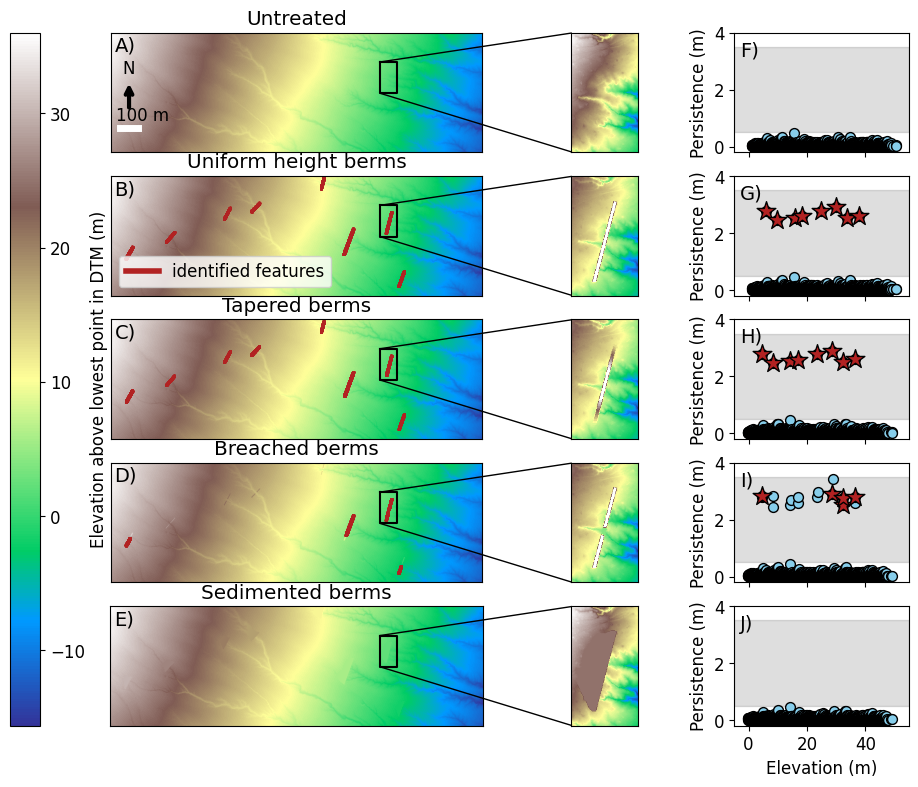

In [62]:
# version of figure with each site separately

import matplotlib.gridspec as gridspec
from skimage import measure
from skimage import filters
from matplotlib.patches import ConnectionPatch

xmin = 1475
xmax = 1570
ymin = 160
ymax = 331
xpos = -8

%matplotlib inline
plt.rcParams.update({'font.size': 12})

# thresh = 1
# max_thresh = 3
# noisethresh = 7
# minelev = 31
cmap='terrain'

fig2 = plt.figure(figsize = (7.25*1.6,6*1.5))
spec2 = gridspec.GridSpec(ncols=25, nrows=5, figure=fig2)
ax0 = fig2.add_subplot(spec2[:, 0]) # this is the colorbar
ax1 = fig2.add_subplot(spec2[0, 1:15]) # this is the elevation image without berms
ax2 = fig2.add_subplot(spec2[1, 1:15]) # elevation image with berms
ax3 = fig2.add_subplot(spec2[0, 20:]) # PD without berms
ax4 = fig2.add_subplot(spec2[1, 20:]) # PD with berms

# add in some zoom-ins
ax10 = fig2.add_subplot(spec2[0, 15:18])
ax11 = fig2.add_subplot(spec2[1, 15:18])
ax12 = fig2.add_subplot(spec2[2, 15:18])
ax13 = fig2.add_subplot(spec2[3, 15:18])
ax14 = fig2.add_subplot(spec2[4, 15:18])

# ax5 = fig2.add_subplot(spec2[2:, 0]) # this is the colorbar
ax6 = fig2.add_subplot(spec2[2, 1:15]) # this is the elevation image without berms
ax7 = fig2.add_subplot(spec2[3, 1:15]) # elevation image with berms
ax8 = fig2.add_subplot(spec2[2, 20:]) # PD without berms
ax9 = fig2.add_subplot(spec2[3, 20:]) # PD with berms
ax97 = fig2.add_subplot(spec2[4, 1:15]) # PD with berms
ax98 = fig2.add_subplot(spec2[4, 20:]) # PD with berms

idx_save = []

xcycles = []
ycycles = []

textlabel = ['A)','B)','C)','D)','E)']
axs = [ax1,ax2,ax6,ax7,ax97]
masks = []
js = [2,3,7,8,9]
for i in range(len(js)):
  ax = axs[i]
  j = js[i]
  shw = ax.imshow(data2[j]+minelev, cmap = cmap, )
  ax.text(20,100,textlabel[i],fontsize=14,c='black')
  ax.set_xticks([])
  ax.set_yticks([])
  idxs = np.arange(dgm0[j].shape[0])
  idxs = idxs[np.abs(dgm0[j][:, 1] - dgm0[j][:, 0]) > thresh]
  xvals, yvals = cocycles_to_plot(cocycles[j],data2[j],rotate=False)
  xvals, yvals = np.array(xvals), np.array(yvals)
  mask_all = (xvals>noisethresh)&(xvals<len(data2[j][0])-noisethresh)&(yvals>noisethresh)&(yvals<len(data2[j])-noisethresh)
  masks.append(mask_all)
  xcycle = np.array(xvals)[idxs]
  ycycle = np.array(yvals)[idxs]
  mask = (xcycle>noisethresh)&(xcycle<len(data2[j][0])-noisethresh)&(ycycle>noisethresh)&(ycycle<len(data2[j])-noisethresh)
  xcycle = xcycle[mask]
  ycycle = ycycle[mask]
  idxs = idxs[mask]
  idx_save.append(idxs)
  counter = len(xcycle)
  xcycles.append(xcycle)
  ycycles.append(ycycle)


  # # plot cycle locations as stars
  # ax.scatter(xcycle,ycycle,color='firebrick', marker='*',clip_on=False,
  #            s=200,edgecolor = 'k',label = 'identified features',
  #            )

  

  if i in [0]:
    ax.plot([50,150],[520,520],lw=5,c='white')
    ax.text(30,480,'100 m')
    # ax.legend(loc='upper right')

cbar = fig2.colorbar(shw, cax=ax0, shrink=1)
cbar.set_label('Elevation above lowest point in DTM (m)')


births,deaths,persistence,births_berm,deaths_berm,persistence_berm = persitence_subs(dgm0[2],dgm0[3],idx_save[1],masks[0],masks[1])

# instead, plot identified features

ax = ax2
i = 3
xcycle = xcycles[i-2]
ycycle = ycycles[i-2]
mask_final=[]
for l in range(len(xcycle)):
  
  splot = np.where((data2[i]> -deaths_berm[1][l]) & (data2[i]<=-births_berm[1][l]),1,0)



  dist = 10

  all_labels = measure.label(splot)
  blobs_labels = measure.label(splot, background=0)

  poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist,max(0,xcycle[l]-dist):xcycle[l]].flatten()))
  poss_comps = [p for p in poss_comps if p>1]

  if len(poss_comps)==0:
      dist1 = dist*2
      poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist1,max(0,xcycle[l]-dist):xcycle[l]].flatten()))
      poss_comps = [p for p in poss_comps if p>1]
  if len(poss_comps)>1:
    dist1 = int(dist/2)
    poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist1,max(0,xcycle[l]-dist):xcycle[l]].flatten()))
    poss_comps = [p for p in poss_comps if p>10]
    if len(poss_comps)>1:
      dist1 = int(dist/4)
      poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist1,max(0,xcycle[l]-dist):xcycle[l]].flatten()))
      poss_comps = [p for p in poss_comps if p>1]
    if len(poss_comps)==0:
      dist1 = int(dist)
      poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist1,max(0,xcycle[l]-dist):xcycle[l]].flatten()))
      poss_comps = [p for p in poss_comps if p>1]
  if len(poss_comps)>1:
    poss_comps = [poss_comps[-1]]

  
  blob_thisonly = np.where(blobs_labels==poss_comps[0],1,np.nan)

  # ax.imshow(blob_thisonly, cmap='Reds_r',vmax=1,zorder = 100)
  # instead, plot as scatter points so it can be bolder
  blob_points = np.argwhere(~np.isnan(blob_thisonly))
  blob_ys = [p[0] for p in blob_points]
  blob_xs = [p[1] for p in blob_points]
  # ax.scatter(blob_xs, blob_ys, c = 'firebrick', s = 1, )
  splot_height = data2[i][blobs_labels==poss_comps[0]]
  meanheight = splot_height-np.nanmin(splot_height)
  meanheight = np.nanmean(meanheight)
  persheight = deaths_berm[1][l]-births_berm[1][l]
  heightratio = persheight / meanheight

  # filter based on size and length
  feature_size = len(blob_points)
  num_features = 0
  if feature_size<maxsize_stockpond:
      D = pdist(blob_points)
      D = squareform(D)
      feature_length, [I_row, I_col] = np.nanmax(D), np.unravel_index( np.argmax(D), D.shape )
      feature_width = feature_size / feature_length
      # print(N)
  else:
      feature_length = 1
      feature_width = 1

  mask = (feature_size>minsize) & (feature_size<maxsize) &(feature_length>minlength) & (feature_length<maxlength) & (feature_width<maxwidth) & (feature_length> 6*feature_width)
  
  if mask:
      ax.scatter(blob_xs, blob_ys, c = 'firebrick', s = 1, label = None)
      #         print(l, feature_size, feature_length, feature_width, heightratio, '(',xcycle[l],',',ycycle[l],')')
      mask_final.append(True)
      num_features += 1
  else:
      mask_final.append(False)

  # if l==6:
  #   ax11.scatter(np.array(blob_xs)-xmin, 
  #             np.array(blob_ys)-ymin, c = 'firebrick', s = .5, alpha=0.1)

ax.plot([0,1],[0,1],c='firebrick',lw=4,zorder = -1,label = 'identified features')
ax.legend()


# end plotting identified features

keys = [0,1]
axs = [ax3,ax4]
textlabel = ['F)','G)']
for key in keys:
  ax = axs[key]
  #Plot horizontal
  ax.scatter((births[key]+deaths[key])/2+4.5,
            persistence[key],
            label='background',c='skyblue',edgecolor = 'k',s=50, )
  try:
    ax.scatter((births_berm[key]+deaths_berm[key])[mask_final]/2+4.5,
             persistence_berm[key][mask_final],c='firebrick',edgecolor='k',s=200,label='berms',
             marker = '*')
  except:
    ax.scatter((births_berm[key]+deaths_berm[key])/2+4.5,
             persistence_berm[key],c='firebrick',edgecolor='k',s=200,label='berms',
             marker = '*')
  ax.axhspan(thresh,max_thresh,
                 facecolor='k',alpha=0.13,edgecolor = 'k',zorder = -1)
  ax.set_ylabel("Persistence (m)")
  # ax.text(xpos,2.6,textlabel[key],fontsize = 14)
  i = i+1
  # if key==0:
  #   ax.legend(loc='upper right')

births,deaths,persistence,births_berm,deaths_berm,persistence_berm = persitence_subs(dgm0[2],dgm0[7],idx_save[2],masks[0],masks[2])

# instead, plot identified features

ax = ax6
i = 2
j = 7
xcycle = xcycles[i]
ycycle = ycycles[i]
mask_final=[]
for l in range(len(xcycle)):
  
  splot = np.where((data2[j]> -deaths_berm[1][l]) & (data2[j]<=-births_berm[1][l]),1,0)



  dist = 10

  all_labels = measure.label(splot)
  blobs_labels = measure.label(splot, background=0)

  poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist,xcycle[l]-dist:xcycle[l]].flatten()))
  poss_comps = [p for p in poss_comps if p>0]

  if len(poss_comps)==0:
      dist1 = dist*2
      poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist1,xcycle[l]-dist1:xcycle[l]].flatten()))
      poss_comps = [p for p in poss_comps if p>0]
  if len(poss_comps)>1:
    dist1 = int(dist/2)
    poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist1,xcycle[l]-dist1:xcycle[l]].flatten()))
    poss_comps = [p for p in poss_comps if p>0]
    if len(poss_comps)>1:
      dist1 = int(dist/4)
      poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist1,xcycle[l]-dist1:xcycle[l]].flatten()))
      poss_comps = [p for p in poss_comps if p>0]
    if len(poss_comps)==0:
      dist1 = int(dist)
      poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist1,xcycle[l]-dist1:xcycle[l]].flatten()))
      poss_comps = [p for p in poss_comps if p>0]

  blob_thisonly = np.where(blobs_labels==poss_comps[0],1,np.nan)

  # ax.imshow(blob_thisonly, cmap='Reds_r',vmax=1,zorder = 100)
  # instead, plot as scatter points so it can be bolder
  blob_points = np.argwhere(~np.isnan(blob_thisonly))
  blob_ys = [p[0] for p in blob_points]
  blob_xs = [p[1] for p in blob_points]
  # ax.scatter(blob_xs, blob_ys, c = 'firebrick', s = 1)
  splot_height = data2[j][blobs_labels==poss_comps[0]]
  meanheight = splot_height-np.nanmin(splot_height)
  meanheight = np.nanmean(meanheight)
  persheight = deaths_berm[1][l]-births_berm[1][l]
  heightratio = persheight / meanheight

  # filter based on size and length
  feature_size = len(blob_points)
  num_features = 0
  if feature_size<maxsize_stockpond:
      D = pdist(blob_points)
      D = squareform(D)
      feature_length, [I_row, I_col] = np.nanmax(D), np.unravel_index( np.argmax(D), D.shape )
      feature_width = feature_size / feature_length
      # print(N)
  else:
      feature_length = 1
      feature_width = 1

  mask = (feature_size>minsize) & (feature_size<maxsize) &(feature_length>minlength) & (feature_length<maxlength) & (feature_width<maxwidth) & (feature_length> 6*feature_width)
  
  if mask:
      ax.scatter(blob_xs, blob_ys, c = 'firebrick', s = 1, label = None)
      #         print(l, feature_size, feature_length, feature_width, heightratio, '(',xcycle[l],',',ycycle[l],')')
      mask_final.append(True)
      num_features += 1
  else:
      mask_final.append(False)

  # if l==6:
  #   ax12.scatter(np.array(blob_xs)-xmin, 
  #             np.array(blob_ys)-ymin, c = 'firebrick', s = .5, alpha=0.1)


textlabel = ['','G)',]
key = 1
ax = ax8
#Plot horizontal
ax.scatter((births[key]+deaths[key])/2+4.5,
          persistence[key],
          label='background',c='skyblue',edgecolor = 'k',s=50, )
ax.scatter((births_berm[key]+deaths_berm[key])[mask_final]/2+4.5,
            persistence_berm[key][mask_final],c='firebrick',edgecolor='k',s=200,label='berms',
            marker = '*')
ax.axhspan(thresh,max_thresh,
                facecolor='k',alpha=0.13,edgecolor = 'k',zorder = -1)
ax.set_ylabel("Persistence (m)")
# ax.text(xpos,2.6,textlabel[key],fontsize = 14)
i = i+1
# if key==0:
#   ax.legend(loc='upper right')

births,deaths,persistence,births_berm,deaths_berm,persistence_berm = persitence_subs(dgm0[2],dgm0[8],idx_save[3],masks[0],masks[3])

# instead, plot identified features

ax = ax7
i = 3
j = 8
xcycle = xcycles[i]
ycycle = ycycles[i]
mask_final=[]
for l in range(len(xcycle)):

  if abs(deaths_berm[1][l]-births_berm[1][l])>3:
    colorplot = 'violet'
    zorder = 20
    alpha = 1
  else:
    colorplot = 'firebrick'
    zorder = 30
    alpha = 1
  splot = np.where((data2[j]> -deaths_berm[1][l]) & (data2[j]<=-births_berm[1][l]),1,0)



  dist = 10

  all_labels = measure.label(splot)
  blobs_labels = measure.label(splot, background=0)


  poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist,
                                     max(xcycle[l]-dist,0):xcycle[l]].flatten()))
  poss_comps = [p for p in poss_comps if p>1]
  # print(l,poss_comps)

  if len(poss_comps)==0:
      dist1 = dist*2
      poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist1,
                                         max(xcycle[l]-dist,0):xcycle[l]].flatten()))
      poss_comps = [p for p in poss_comps if p>1]
  if len(poss_comps)>1:
    dist1 = int(dist/2)
    poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist1,
                                       max(xcycle[l]-dist,0):xcycle[l]].flatten()))
    poss_comps = [p for p in poss_comps if p>1]
    while len(poss_comps)>1:
      dist1 = int(dist1/2)
      poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist1,
                                         max(xcycle[l]-dist,0):xcycle[l]].flatten()))
      poss_comps = [p for p in poss_comps if p>1]
    if len(poss_comps)==0:
      # print('rat',dist1)
      if dist1==0:
        dist1 = 1
      else:
        dist1 = round(dist1*2)
      poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist1,
                                         max(xcycle[l]-dist,0):xcycle[l]].flatten()))
      poss_comps = [p for p in poss_comps if p>1]

  if len(poss_comps)>1:
    poss_comps = [poss_comps[-1]]

  blob_thisonly = np.where(blobs_labels==poss_comps[0],1,np.nan)

  # ax.imshow(blob_thisonly, cmap='Reds_r',vmax=1,zorder = 100)
  # instead, plot as scatter points so it can be bolder
  blob_points = np.argwhere(~np.isnan(blob_thisonly))
  blob_ys = [p[0] for p in blob_points]
  blob_xs = [p[1] for p in blob_points]
  # ax.scatter(blob_xs, blob_ys, c = colorplot, s = 1, zorder = zorder, alpha=alpha)
  splot_height = data2[j][blobs_labels==poss_comps[0]]
  meanheight = splot_height-np.nanmin(splot_height)
  meanheight = np.nanmean(meanheight)
  persheight = deaths_berm[1][l]-births_berm[1][l]
  heightratio = persheight / meanheight

  # filter based on size and length
  feature_size = len(blob_points)
  num_features = 0
  if feature_size<maxsize_stockpond:
      D = pdist(blob_points)
      D = squareform(D)
      feature_length, [I_row, I_col] = np.nanmax(D), np.unravel_index( np.argmax(D), D.shape )
      feature_width = feature_size / feature_length
      # print(N)
  else:
      feature_length = 1
      feature_width = 1

  mask = (feature_size>minsize) & (feature_size<maxsize) &(feature_length>minlength) & (feature_length<maxlength) & (feature_width<maxwidth) & (feature_length> 6*feature_width)
  
  if mask:
      ax.scatter(blob_xs, blob_ys, c = 'firebrick', s = 1, label = None)
      #         print(l, feature_size, feature_length, feature_width, heightratio, '(',xcycle[l],',',ycycle[l],')')
      mask_final.append(True)
      num_features += 1
  else:
      mask_final.append(False)


  # if l in [12,13]:
  #   ax13.scatter(np.array(blob_xs)-xmin, 
  #             np.array(blob_ys)-ymin, c = colorplot, s = .5, zorder = zorder, alpha=.1)

  



ax = ax9
textlabel = ['G)','H)']
key = 1
#Plot horizontal
ax.scatter((births[key]+deaths[key])/2+4.5,
          persistence[key],
          label='background',c='skyblue',edgecolor = 'k',s=50, )

ax.scatter((births_berm[key]+deaths_berm[key])[mask_final]/2+4.5,
          persistence_berm[key][mask_final],c='firebrick',edgecolor='k',s=200,label='berms',
          marker = '*')
ax.axhspan(thresh,max_thresh,
                facecolor='k',alpha=0.13,edgecolor = 'k',zorder = -1)
ax.set_ylabel("Persistence (m)")
# ax.text(xpos,2.6,textlabel[key],fontsize = 14)

births,deaths,persistence,births_berm,deaths_berm,persistence_berm = persitence_subs(dgm0[2],dgm0[9],idx_save[4],masks[0],masks[4])

# instead, plot identified features

ax = ax97
i = 4
j = 9
xcycle = xcycles[i]
ycycle = ycycles[i]
mask_final=[]
for l in range(len(xcycle)):

  if abs(deaths_berm[1][l]-births_berm[1][l])>3:
    colorplot = 'violet'
    zorder = 20
    alpha = 1
  else:
    colorplot = 'firebrick'
    zorder = 30
    alpha = 1
  splot = np.where((data2[j]> -deaths_berm[1][l]) & (data2[j]<=-births_berm[1][l]),1,0)



  dist = 10

  all_labels = measure.label(splot)
  blobs_labels = measure.label(splot, background=0)


  poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist,
                                     max(xcycle[l]-dist,0):xcycle[l]].flatten()))
  poss_comps = [p for p in poss_comps if p>1]
  # print(l,poss_comps)

  if len(poss_comps)==0:
      dist1 = dist*2
      poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist1,
                                         max(xcycle[l]-dist,0):xcycle[l]].flatten()))
      poss_comps = [p for p in poss_comps if p>1]
  if len(poss_comps)>1:
    dist1 = int(dist/2)
    poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist1,
                                       max(xcycle[l]-dist,0):xcycle[l]].flatten()))
    poss_comps = [p for p in poss_comps if p>1]
    while len(poss_comps)>1:
      dist1 = int(dist1/2)
      poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist1,
                                         max(xcycle[l]-dist,0):xcycle[l]].flatten()))
      poss_comps = [p for p in poss_comps if p>1]
    if len(poss_comps)==0:
      # print('rat',dist1)
      if dist1==0:
        dist1 = 1
      else:
        dist1 = round(dist1*2)
      poss_comps = list(set(blobs_labels[ycycle[l]:ycycle[l]+dist1,
                                         max(xcycle[l]-dist,0):xcycle[l]].flatten()))
      poss_comps = [p for p in poss_comps if p>1]

  if len(poss_comps)>1:
    poss_comps = [poss_comps[-1]]

  blob_thisonly = np.where(blobs_labels==poss_comps[0],1,np.nan)

  # ax.imshow(blob_thisonly, cmap='Reds_r',vmax=1,zorder = 100)
  # instead, plot as scatter points so it can be bolder
  blob_points = np.argwhere(~np.isnan(blob_thisonly))
  blob_ys = [p[0] for p in blob_points]
  blob_xs = [p[1] for p in blob_points]
  # ax.scatter(blob_xs, blob_ys, c = colorplot, s = 1, zorder = zorder, alpha=alpha)
  splot_height = data2[j][blobs_labels==poss_comps[0]]
  meanheight = splot_height-np.nanmin(splot_height)
  meanheight = np.nanmean(meanheight)
  persheight = deaths_berm[1][l]-births_berm[1][l]
  heightratio = persheight / meanheight

  # filter based on size and length
  feature_size = len(blob_points)
  num_features = 0
  if feature_size<maxsize_stockpond:
      D = pdist(blob_points)
      D = squareform(D)
      feature_length, [I_row, I_col] = np.nanmax(D), np.unravel_index( np.argmax(D), D.shape )
      feature_width = feature_size / feature_length
      # print(N)
  else:
      feature_length = 1
      feature_width = 1

  mask = (feature_size>minsize) & (feature_size<maxsize) &(feature_length>minlength) & (feature_length<maxlength) & (feature_width<maxwidth) & (feature_length> 6*feature_width)
  
  if mask:
      ax.scatter(blob_xs, blob_ys, c = 'firebrick', s = 1, label = None)
      #         print(l, feature_size, feature_length, feature_width, heightratio, '(',xcycle[l],',',ycycle[l],')')
      mask_final.append(True)
      num_features += 1
  else:
      mask_final.append(False)

ax = ax98
key = 1
#Plot horizontal
ax.scatter(((births[key]+deaths[key])/2+4.5),
          persistence[key],
          label='background',c='skyblue',edgecolor = 'k',s=50, )
mask = persistence_berm[key] < 3
bsmall = births_berm[key][mask_final][mask]
dsmall = deaths_berm[key][mask_final][mask]
psmall = persistence_berm[key][mask_final][mask]
ax.scatter(((bsmall+dsmall)/2+4.5),
            psmall,c='firebrick',edgecolor='k',s=200,label='berms',
            marker = '*')
# mask = persistence_berm[key] >= 3
# bbig = births_berm[key][mask]
# dbig = deaths_berm[key][mask]
# pbig = persistence_berm[key][mask]
# ax.scatter(((bbig+dbig)/2+4.5),
#             pbig,c='violet',edgecolor='k',s=200,label='berms',
#             marker = '*',zorder = 10000)
ax.axhspan(thresh,max_thresh,
                facecolor='k',alpha=0.13,edgecolor = 'k',zorder = -1)
ax.set_ylabel("Persistence (m)")



axs[0].set_xticklabels([]) 
ax98.set_xlabel("Elevation (m)")

ax1.annotate('N', (100, 425),
            xytext=(100, 225),
             arrowprops=dict(facecolor='black', 
                             arrowstyle='<-',
                             lw = 3),ha = 'center')




# add zoom-in sections
for ax in [ax1, ax2, ax6, ax7, ax97]:
  ax.plot([xmin,xmax,xmax,xmin,xmin],
         [ymin,ymin,ymax,ymax,ymin], c = 'k')
  
axplot = [ax10, ax11, ax12, ax13, ax14]
axoriginal = [ax1,ax2,ax6,ax7,ax97]
useplot = [2,3,7,8,9]

mind = 0
maxd = 36


for k in range(len(axplot)):
  ax = axplot[k]
  ax.imshow(data2[useplot[k]][ymin:ymax+1,xmin:xmax+1]+minelev,#vmin = mind, vmax = maxd,
            cmap = cmap)
  ax.set_xticks([])
  ax.set_yticks([])
  con = ConnectionPatch(xyA=(xmin,ymin), xyB=(0,0), coordsA="data", coordsB="data",
                      axesA=axoriginal[k], axesB=axplot[k], color="k")
  axoriginal[k].add_artist(con)
  con = ConnectionPatch(xyA=(xmin,ymax), xyB=(0,ymax-ymin), coordsA="data", coordsB="data",
                      axesA=axoriginal[k], axesB=axplot[k], color="k")
  axoriginal[k].add_artist(con)

ax1.set_title('Untreated')
ax2.set_title('Uniform height berms')
ax6.set_title('Tapered berms')
ax7.set_title('Breached berms')
ax97.set_title('Sedimented berms')

l=0
labels = ['F)','G)','H)','I)','J)']
for ax in [ax3,ax4,ax8,ax9,ax98]:
  ax.set_xlim(-5,55)
  ax.set_ylim(-.2,4)
  ax.text(-3,3.2,labels[l],fontsize = 14)
  if l<4:
    ax.set_xticklabels([])
  l+=1

# fig2.tight_layout()
# # # plt.subplots_adjust(wspace=-.4)

# fig2.suptitle('Site 2')

plt.savefig('/content/synthetic_berms_r1_site2.png',format='png',dpi=300,bbox_inches='tight')